In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter


In [ ]:
import kagglehub
path = kagglehub.dataset_download("nikhil1e9/loan-default")

df = pd.read_csv(f"{path}/Loan_default.csv")
df.head()

100%|██████████| 7.86M/7.86M [00:00<00:00, 46.5MB/s]

Extracting files...


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [ ]:
print("Initial Shape:", df.shape)

Initial Shape: (255347, 18)


In [ ]:
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate Rows: 0


In [ ]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [ ]:
if 'LoanID' in df.columns:
    df = df.drop('LoanID', axis=1)

In [ ]:
print("\nCleaned Shape:", df.shape)


Cleaned Shape: (255347, 17)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  object 
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

In [ ]:
# Separate feature types
# num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed',
            'NumCreditLines','InterestRate','LoanTerm','DTIRatio']

#cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = ['Education','EmploymentType','MaritalStatus','HasMortgage',
            'HasDependents','LoanPurpose','HasCoSigner']

target = 'Default'


print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numeric Columns: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical Columns: ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [ ]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (204277, 24)
Testing shape: (51070, 24)


**Apply SMOTE (Synthetic Minority Over-sampling Technique)**

This balance the dataset and helps models learn patterns from both classes equally.

In [ ]:
# Before balancing
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# After balancing
print("After SMOTE:", Counter(y_train_bal))

Before SMOTE: Counter({0: 180555, 1: 23722})
After SMOTE: Counter({0: 180555, 1: 180555})


In [ ]:
# --- Logistic Regression ---

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_bal, y_train_bal)
y_pred_log = log_model.predict(X_test)

print("\n Logistic Regression ")
print("\nAccuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


 Logistic Regression 

Accuracy: 0.6692187194047386

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.78     45139
           1       0.21      0.66      0.32      5931

    accuracy                           0.67     51070
   macro avg       0.57      0.67      0.55     51070
weighted avg       0.85      0.67      0.73     51070


Confusion Matrix:
 [[30248 14891]
 [ 2002  3929]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# --- Random Forest ---

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test)

print("\n Random Forest ")
print("\nAccuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


 Random Forest 

Accuracy: 0.8731936557665949

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     45139
           1       0.34      0.09      0.15      5931

    accuracy                           0.87     51070
   macro avg       0.61      0.53      0.54     51070
weighted avg       0.83      0.87      0.84     51070


Confusion Matrix:
 [[44037  1102]
 [ 5374   557]]


In [ ]:
# --- Naive Bayes ---

# Train model
nb_model = GaussianNB()
nb_model.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print(" Naive Bayes Results ")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

 Naive Bayes Results 
Accuracy: 0.6916976698648913

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.70      0.80     45139
           1       0.21      0.62      0.32      5931

    accuracy                           0.69     51070
   macro avg       0.57      0.66      0.56     51070
weighted avg       0.85      0.69      0.74     51070

Confusion Matrix:
 [[31641 13498]
 [ 2247  3684]]


In [ ]:
# --- XGBoost ---

# Train the model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_bal, y_train_bal)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate results
print("\n XGBoost Results ")
print("\nAccuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


 XGBoost Results 

Accuracy: 0.8848834932445663

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.52      0.10      0.16      5931

    accuracy                           0.88     51070
   macro avg       0.71      0.54      0.55     51070
weighted avg       0.85      0.88      0.85     51070


Confusion Matrix:
 [[44623   516]
 [ 5363   568]]


In [ ]:
# Dictionary to store model results dynamically
results = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_log),
        'Recall': recall_score(y_test, y_pred_log),
        'F1': f1_score(y_test, y_pred_log)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1': f1_score(y_test, y_pred_rf)
    },
    'Naive Bayes': {
        'Accuracy': accuracy_score(y_test, y_pred_nb),
        'Recall': recall_score(y_test, y_pred_nb),
        'F1': f1_score(y_test, y_pred_nb)
    },
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1': f1_score(y_test, y_pred_xgb)
    }
}

# Convert to DataFrame
df_results = pd.DataFrame(results).T.reset_index()
df_results.rename(columns={'index': 'Model'}, inplace=True)

# Convert decimal values to %
df_results[['Accuracy', 'Recall', 'F1']] = df_results[['Accuracy', 'Recall', 'F1']] * 100
df_results = df_results.round(2)  # Round to 2 decimal places

# Display table
print(" Model Comparison (%):")
display(df_results)

 Model Comparison (%):


,Model,Accuracy,Recall,F1
0,Logistic Regression,66.92,66.25,31.75
1,Random Forest,87.32,9.39,14.68
2,Naive Bayes,69.17,62.11,31.88
3,XGBoost,88.49,9.58,16.19


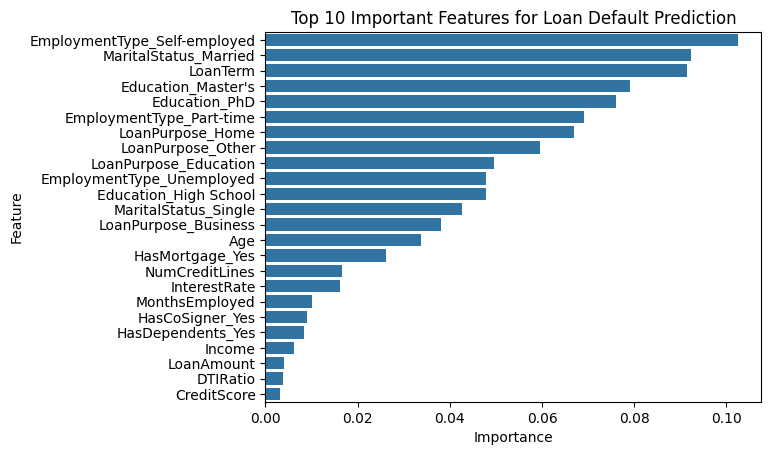

In [ ]:
importances = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title("Top 10 Important Features for Loan Default Prediction")
plt.show()